In [1]:
using Pkg;
const root = dirname(@__DIR__)
Pkg.activate(root);
Pkg.instantiate()
#Pkg.add("Convex")
#Pkg.add("SCS")

  Activating environment at `~/Projects/robotsim/stable-manipulation/Project.toml`


In [2]:
#using Convex, SCS
using LinearAlgebra
using ForwardDiff
using Plots
using OrdinaryDiffEq
using Ipopt
using MathOptInterface
const MOI = MathOptInterface
using Test

In [3]:
#const g = 9.81
const g = 0.0
const m = 1
μ = 0.1
dqref = [-0.1; 0]

2-element Vector{Float64}:
 -0.1
  0.0

In [4]:
# hybrid flows for sliding particle
function f_free(x, u)
    q = x[1:2]
    dq = x[3:4]
    ddq = u/m
    return [dq; ddq]
end

function f_stick(x, u)
    q = x[1:2]
    dq = x[3:4]
    ddq = zeros(eltype([x;u]),2)
    return [dq; ddq]
end

function f_leftslide(x, u)
    q = x[1:2]
    dq = x[3:4]
    ddq = [(u[1] - μ*u[2])/m; zero(eltype([x;u]))]
    
    return [dq; ddq]
end

function f_rightslide(x, u)
    q = x[1:2]
    dq = x[3:4]
    ddq = [(u[1] + μ*u[2])/m; zero(eltype([x;u]))]
    return [dq; ddq]
end

f_rightslide (generic function with 1 method)

In [5]:
# domain: 
# ineqs > 0, eqs = 0
function domain_free(x)
    ineqs = [x[2]]
    eqs = []
    return ineqs, eqs
end

function domain_stick(x)
    ineqs = []
    eqs = [x[2]; x[3]; x[4]]
    return ineqs, eqs
end

function domain_leftslide(x)
    ineqs = [-x[3]]
    eqs = [x[2]; x[4]]
    return ineqs, eqs
end

function domain_rightslide(x)
    ineqs = [x[3]]
    eqs = [x[2]; x[4]]
    return ineqs, eqs
end

domain_rightslide (generic function with 1 method)

In [6]:
# jump maps
function jump_free2l(x)
    return [x[1:2]; [x[3] - μ*x[4];0]]
end

jump_free2l (generic function with 1 method)

In [7]:
# guard
function guard_free2l(x)
    ineqs = [-1 μ; 0 -1]*x[3:4]
    eqs = [x[2]]
    return ineqs, eqs
end

guard_free2l (generic function with 1 method)

In [8]:
# Lyapunov function
function V(x)
    dq = x[2:4]
    v = (x[2:4] - [0;dqref])'*Diagonal([1; 1; 1])*(x[2:4] - [0;dqref])
    return v
end

function dVdx(x)
    res =[0 1 1 1].*(x' - [0 0  dqref'])
    return res
end


dVdx (generic function with 1 method)

In [9]:
#Boilerplate setup code to interface with IPOPT. Don't touch this except to turn on/off verbose IPOPT if you want (see comment below).

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    objective
    constraint!
    primal_bounds
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    constraint_bounds
    hessian_lagrangian::Bool
end


In [10]:

function ProblemMOI(n_nlp,m_nlp,objective, constraint!, primal_bounds;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        objective, constraint!,
        primal_bounds,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        constraint_bounds,
        hessian_lagrangian)
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)

    c_u = zeros(m)
    c_u[idx_ineq] .= Inf
    
    return c_l, c_u
end

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end

function sparsity_jacobian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    prob.objective(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,prob.objective,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    prob.constraint!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), prob.constraint!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function ipopt_solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=1000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    
    #Uncomment the following line to turn off verbose IPOPT output
    #solver.options["print_level"] = 0

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

ipopt_solve (generic function with 1 method)

### Single Timestep
solve for $u$ only

In [11]:
# tweak x0 to see different u
x0 = [0;0;-0.099;0]

4-element Vector{Float64}:
  0.0
  0.0
 -0.099
  0.0

In [12]:
#Objective and constraint functions for IPOPT

function objective(z)
    u = z[1:2] -[0;-10]
    β = z[3:24]
    α = z[25:28] .- 5
#     l = u'*u + β'*β + α'*α
    l = (z[2] + 10)^2 + β'*β + α'*α
    return l
end

function constraint!(c,z)
    u = z[1:2]
    β = z[3:24]
    α = z[25:28]
    
    x = x0

    Vx = dVdx(x)
    Vv = V(x)
    
    # free
    d_ineq_free, d_eq_free = domain_free(x)
    c_free = -Vx*f_free(x,u) - β[1]*d_ineq_free 
    
    g_ineq_free, g_eq_free = guard_free2l(x)
    
    c_free_jump = -(Vx*f_free(jump_free2l(x),u) .+ α[1]*Vv) - .- β[3:4]'*g_ineq_free .- β[5]*g_eq_free .- β[6]*(-g_eq_free)
    
    # left sliding
    d_ineq_l, d_eq_l = domain_leftslide(x)
    c_l = -(Vx*f_leftslide(x,u) .+ α[2]*Vv).- β[7]*d_ineq_l .- β[8:9]'*d_eq_l .- β[10:11]'*(-d_eq_l)
    
    # sticking 
    d_ineq_s, d_eq_s = domain_stick(x)
    c_s = -(Vx*f_stick(x,u) .+ α[3]*Vv ) .- β[12:14]'*d_eq_s .- β[15:17]'*(-d_eq_s)
    c_s_jump = - (Vx*f_leftslide(x,u) .+ α[4]*Vv)  .- β[17:19]'*d_eq_s .- β[20:22]'*(-d_eq_s)
    
    c .= [c_free; c_free_jump; c_l; c_s; c_s_jump]
    
    return nothing
end

#Specify the indicies of c (constraint output) that should be non-negative.
#The rest will be treated as equality constraints.
#This can vary depending on how you stacked up c above.

nonnegative_constraint_indices = (1:5) # update this

function primal_bounds(n)
    #Enforce simple bound constraints on the decision variables (e.g. positivity) here
    # x_l ≤ [u; β] ≤ x_u
    
    # TODO: update these 
    x_l = [-Inf*ones(2);zeros(n-2)]
    x_u = [20*ones(2);Inf*ones(n-4); 10*ones(4)]

    return x_l, x_u
end

primal_bounds (generic function with 1 method)

In [13]:
# n_nlp: number of variables
n_nlp = 2 + 26
# m_nlp: number of constraints
m_nlp = 5
control_prob = ProblemMOI(n_nlp,m_nlp, objective,constraint!, primal_bounds(n_nlp), idx_ineq=nonnegative_constraint_indices);
# zc_guess = [1;1;zeros(26)]
# zc_sol = ipopt_solve(zc_guess,control_prob);

In [14]:
#print(zc_sol[1:2])

#### next:
- [ ] write the simulation of the particle
- [ ] add some disturbance to drive it away from its current mode
- [ ] compare with a regular controller

### Simulation

In [15]:
const h = 0.05 #20 Hz
const Tf = 1.5 #final time (sec)
thist = Array(0:h:Tf)
N = length(thist)

31

In [16]:
#Signed-distance function for a particle in 2D
function ϕ(q)
    return q[2]
end

Dϕ = [0; 1.0]'

#Discrete Lagrangian stuff
function L(q,q̇)
    0.5*m*q̇'*q̇ - m*g*q[2]
end

function Ld(q1,q2)
    qm = 0.5*(q1 + q2)
    vm = (q2-q1)/h
    return L(qm,vm)
end

function D1Ld(q1,q2)
    return ForwardDiff.gradient(dq1->Ld(dq1,q2),q1)
end

function D2Ld(q1,q2)
    return ForwardDiff.gradient(dq2->Ld(q1,dq2),q2)
end

function DEL(q1,q2,q3,n)
    D2Ld(q1,q2) + D1Ld(q2,q3) + h*Dϕ'*n
end

function DEL(q1,q2,q3,n,b)
    D2Ld(q1,q2) + D1Ld(q2,q3) + h*[b;n]
end

function DEL(q1,q2,q3,n,b, u1, u2)
    D2Ld(q1,q2) + D1Ld(q2,q3) + h*[b;n] + 0.5*h*u1 + 0.5*h*u2
end

function smoothsqrt(x)
    ϵ = 1e-6
    return sqrt(x+ϵ*ϵ) - ϵ
end

smoothsqrt (generic function with 1 method)

In [17]:
#Objective and constraint functions for IPOPT with Friction

function sim_objective(z)
    qn = z[1:2]
    n = z[3]
    b = z[4]
    λ = z[5]
    s = z[6:7]
    
    return sum(s) #Minimize slacks associated with relaxed complementarity conditions
end

function sim_constraint!(c,z)
    qn = z[1:2]
    n = z[3]
    b = z[4]
    λ = z[5]
    s = z[6:7]
    
    vm = (qn-qhist[:,k])/h
    
    c .= [DEL(qhist[:,k-1],qhist[:,k],qn,n,b); #DEL
          [1; 0]'*vm + λ*b/smoothsqrt(b*b); #maximum dissipation
          μ*n - smoothsqrt(b*b); #friction cone
          s[1]-n*ϕ(qn); #relaxed complementarity
          s[2]-λ*(μ*n - smoothsqrt(b*b))] #relaxed complementarity
    
    return nothing
end

function sim_constraint_w_control!(c,z)
    qn = z[1:2]
    n = z[3]
    b = z[4]
    λ = z[5]
    s = z[6:7]
    
    vm = (qn-qhist[:,k])/h
    
    c .= [DEL(qhist[:,k-1],qhist[:,k],qn,n,b, u1, u2); #DEL
          [1; 0]'*vm + λ*b/smoothsqrt(b*b); #maximum dissipation
          μ*n - smoothsqrt(b*b); #friction cone
          s[1]-n*ϕ(qn); #relaxed complementarity
          s[2]-λ*(μ*n - smoothsqrt(b*b))] #relaxed complementarity
    
    return nothing
end

#Specify the indecies of c (constraint output) that should be non-negative.
#The rest will be treated as equality constraints.
sim_nonnegative_constraint_indices = (4:6)

function sim_primal_bounds(n)
    #Enforce simple bound constraints on the decision variables (e.g. positivity) here
    
    x_l = [-Inf; 0; 0; -Inf; zeros(3)]
    x_u = Inf*ones(7)
    
    return x_l, x_u
end

sim_primal_bounds (generic function with 1 method)

In [18]:
#Initial Conditions
q0 = [0; 0.0]
v0 = [0; 0.0]
q1 = q0 + h*v0 + 0.5*h*h*[0; -g]

2-element Vector{Float64}:
 0.0
 0.0

In [19]:
#Solve with IPOPT

# n_sim = 7
# m_sim = 6
# sim_prob = ProblemMOI(n_sim,m_sim,sim_objective, sim_constraint_w_control!, sim_primal_bounds(n_sim), idx_ineq=(3:4));

# #Initial conditions
# qhist = zeros(2,N)
# qhist[:,1] .= q0
# qhist[:,2] .= q1
# u1 = [0;0]
# u2 = [0;0]

# nhist = zeros(N-1)
# bhist = zeros(N-1)
# λhist = zeros(N-1)
# shist = zeros(2,N-1)
# k = 0

# for kk = 2:(N-1)
#     k = kk
    
#     zs_guess = [qhist[:,k]; ones(5)]
#     zs_sol = ipopt_solve(zs_guess,sim_prob);
#     qhist[:,k+1] .= zs_sol[1:2]
#     nhist[k] = zs_sol[3]
#     bhist[k] = zs_sol[4]
#     λhist[k] = zs_sol[5]
#     shist[:,k] .= zs_sol[6:7]
# end


In [20]:
#Solve with IPOPT
n_sim = 7
m_sim = 6
sim_prob = ProblemMOI(n_sim,m_sim,sim_objective, sim_constraint_w_control!, sim_primal_bounds(n_sim), idx_ineq=sim_nonnegative_constraint_indices);


In [21]:
#Initial conditions
qhist = zeros(2,N)
qhist[:,1] .= q0
qhist[:,2] .= q1
u1 = [0;0]
u2 = [0;0]

nhist = zeros(N-1)
bhist = zeros(N-1)
λhist = zeros(N-1)
shist = zeros(2,N-1)
uhist = zeros(2,N)
k = 0


0

In [22]:


for kk = 2:(N-1)
    k = kk
    
    #compute control
    x0 = [qhist[:,k]; 0.5*h.*(qhist[:,k] - qhist[:,k-1])]
    zc_guess = [u2;zeros(26)]
    zc_sol = ipopt_solve(zc_guess,control_prob);
    uhist[:,k+1] = zc_sol[1:2]
    u1 = uhist[:,k]
    u2 = uhist[:,k+1]
    
    zs_guess = [qhist[:,k]; ones(5)]
    zs_sol = ipopt_solve(zs_guess,sim_prob);
    qhist[:,k+1] .= zs_sol[1:2]
    nhist[k] = zs_sol[3]
    bhist[k] = zs_sol[4]
    λhist[k] = zs_sol[5]
    shist[:,k] .= zs_sol[6:7]
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      140
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       28
                     variables with only lower bounds:       24
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        2
Total number of equal

In [23]:
qhist

2×31 Matrix{Float64}:
 0.0  0.0  -0.000507803  -0.00210899  …  -0.698133   -0.761168  -0.82748
 0.0  0.0   6.87341e-9    2.05035e-9      5.6436e-8   0.0        4.98406e-9

In [24]:

# n = N
# x = qhist[1,:]
# y = qhist[2,:]
# anim = @animate for i ∈ 1:n
#     scatter([qhist[1,i]], [qhist[2,i]],
#          m=:circle, c=:blue,
#          markersize=4, legend = false, xlims=(-1,5), ylims=(-1,4))
#     plot!([-2,5],[0,0], lw = 2, c=:orange)

# end
# gif(anim, "anim.gif", fps = 1/h)

┌ Info: Saved animation to 
│   fn = /Users/xianyi/Projects/robotsim/stable-manipulation/src/anim.gif
└ @ Plots /Users/xianyi/.julia/packages/Plots/AJMX6/src/animation.jl:114


Plots.AnimatedGif("/Users/xianyi/Projects/robotsim/stable-manipulation/src/anim.gif")
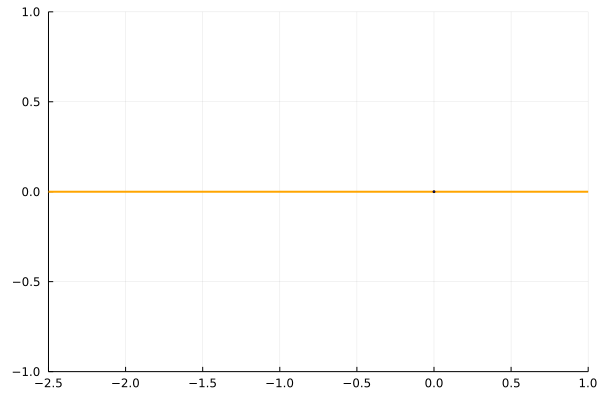

In [25]:
n = N
x = qhist[1,:]
y = qhist[2,:]
plot([-10,5],[0,0], lw = 2, c=:orange, xlims=(-2.5,1), ylims=(-1,1))
anim = @animate for i ∈ 1:n
    
    scatter!([qhist[1,i]], [qhist[2,i]],
         m=:circle, c=:blue,
         markersize=2, legend = false)
end
gif(anim, "anim.gif", fps = 1/h)